In [1]:
using Knet
using Images
using Statistics

if Knet.gpu() >= 0
    ATYPE = KnetArray{Float32}
else
    ATYPE = Array{Float32}
end

Array{Float32,N} where N

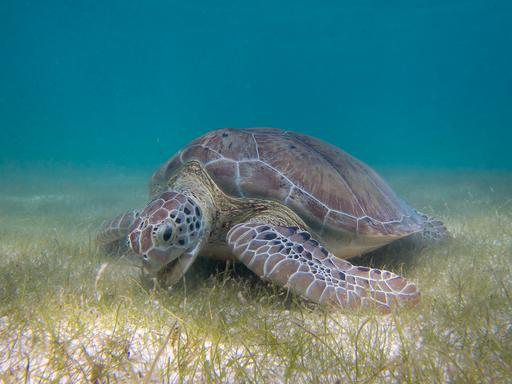

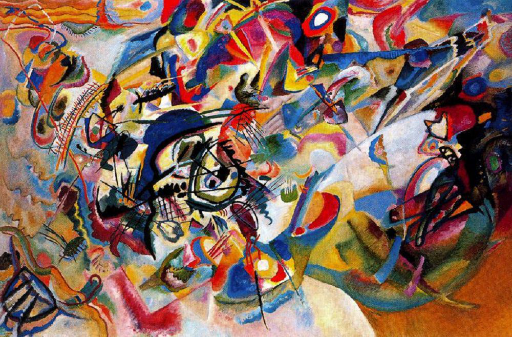

In [2]:
CONTENT_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/Green_Sea_Turtle_grazing_seagrass.jpg"
STYLE_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg"

content_img = load(CONTENT_URL)
style_img = load(STYLE_URL)

ratio = 512 / max(size(content_img)...)
content_img = imresize(content_img, ratio=ratio)
ratio = 512 / max(size(style_img)...)
style_img = imresize(style_img, ratio=ratio)

display(content_img)
display(style_img)

content_img = permutedims(channelview(content_img), (2,3,1)) .|> Float32;
style_img = permutedims(channelview(style_img), (2,3,1)) .|> Float32;

In [3]:
using StyleTransfer

STYLE_LAYERS = [:conv1_1, :conv2_1, :conv3_1, :conv4_1, :conv5_1]
CONTENT_LAYER = :conv5_2

extract_features = FeatureExtractor();
MEAN_COLOR = extract_features.mean_color;

┌ Info: Recompiling stale cache file /home/davll/.julia/compiled/v1.2/StyleTransfer/PbjJi.ji for StyleTransfer [585f4c16-dfb6-11e9-10bd-b5efeb05374f]
└ @ Base loading.jl:1240


In [4]:
function preprocess(x)
    x = x .* 255
    reshape(x,size(x)...,1) .- MEAN_COLOR
end

style_targets = extract_features(style_img |> preprocess, STYLE_LAYERS...) .|> gram_matrix;
content_target = extract_features(content_img |> preprocess, CONTENT_LAYER)[1];

In [12]:
STYLE_LOSS_WEIGHT = 1e-2
CONTENT_LOSS_WEIGHT = 1e4

function style_content_loss(input)
    outputs = extract_features(preprocess(input), STYLE_LAYERS..., CONTENT_LAYER)
    style_outputs = outputs[1:end-1] .|> gram_matrix
    content_output = outputs[end]
    style_loss = mean(mean((so .- st) .^ 2) for (so, st) in zip(style_outputs, style_targets))
    content_loss = mean((content_output .- content_target) .^ 2)
    style_loss * STYLE_LOSS_WEIGHT + content_loss * CONTENT_LOSS_WEIGHT
end

style_content_loss (generic function with 1 method)

In [14]:
image = param(content_img)
@show params(image)

adam!((x) -> style_content_loss(image), [1,2]; params=params(image)) |> progress!

display(colorview(RGB, value(image)))

params(image) = Param[P(Array{Float32,3}(384,512,3))]
style_content_loss(image) = 1.30567282688e9

Stacktrace:
 [1] macro expansion at ./multidimensional.jl:722 [inlined]
 [2] _unsafe_setindex!(::IndexLinear, ::Array{Float32,3}, ::AutoGrad.Result{Array{Float32,3}}, ::Int64, ::Int64, ::Base.Slice{Base.OneTo{Int64}}) at ./multidimensional.jl:717
 [3] _setindex! at ./multidimensional.jl:712 [inlined]
 [4] setindex! at ./abstractarray.jl:1074 [inlined]
 [5] gram_matrix(::AutoGrad.Result{Array{Float32,4}}) at /home/davll/projects/my/StyleTransfer.jl/src/StyleTransfer.jl:26
 [6] |> at ./operators.jl:854 [inlined]
 [7] _broadcast_getindex_evalf at ./broadcast.jl:625 [inlined]
 [8] _broadcast_getindex at ./broadcast.jl:598 [inlined]
 [9] getindex at ./broadcast.jl:558 [inlined]
 [10] macro expansion at ./broadcast.jl:888 [inlined]
 [11] macro expansion at ./simdloop.jl:77 [inlined]
 [12] copyto! at ./broadcast.jl:887 [inlined]
 [13] copyto! at ./broadcast.jl:842 [inlined]
 [14] copy at ./broad

MethodError: MethodError: no method matching setindex_shape_check(::AutoGrad.Result{Array{Float32,3}}, ::Int64, ::Int64, ::Int64)
Closest candidates are:
  setindex_shape_check(!Matched::AbstractArray, ::Integer...) at indices.jl:179
  setindex_shape_check(!Matched::AbstractArray{#s75,1} where #s75, ::Integer, ::Integer) at indices.jl:221
  setindex_shape_check(!Matched::AbstractArray{#s75,2} where #s75, ::Integer, ::Integer) at indices.jl:225
  ...